### Active Learning with Gaussian Process

In my previous post, I had introduced the Gaussian Process. In this post, I am going to focus on the task of active learning - where we query the user/oracle to label samples. The main motivation behind active learning is the expensive cost of labeling in machine learning tasks.

#### Mining Gold!

In this post, we will assume a mining application - mining for gold! We will simplify the problem by stating that we need to search for gold in a 1d search space. At each prospective location, we have to drill a hole and use some expensive sensors to find out the amount of gold in that location. Given the costly nature of this drilling, we would not be able to drill at all locations. Thus, the active learning problem comes into the picture.

#### Problem: Determine which location to next drill


We would be starting with some very naive assumption that the gold distribution of nearby points in similar (smoothness). GPs fit very well in this active learning problem as they give us not only the predictions but also the uncertainty. One popular active learning strategy is to choose the next location to drill (or query in the more general sense) as the location about which we are most uncertain about (highest variance).

Here is a representative animation showing the process of drilling at new locations and reducing the uncertainty. We will build this from the ground up in this post.


![](active-gp.gif)

#### Some imports

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
%matplotlib inline

#### Prettyfing Matplotlib plots

In [2]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

#### Creating ground truth data

In [3]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

Let us now try to see how our groundtruth data looks like.

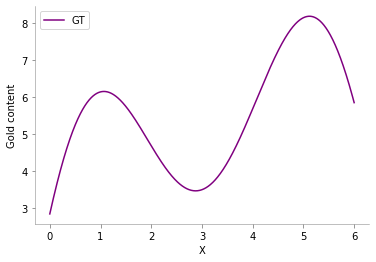

In [4]:
x = np.atleast_2d(np.linspace(0, 6, 1000)).T
plt.plot(x, f(x), color='purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.legend()
format_axes(plt.gca())

#### Plotting our prior model

Our prior model doesn't know much and assumes a smooth relationship between points via an RBF kernel.

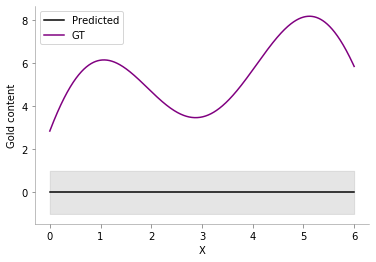

In [5]:
gp = GaussianProcessRegressor()
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted', lw=1.5)
plt.plot(x, f(x), 'purple', label='GT', lw=1.5)
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2)
plt.legend()
format_axes(plt.gca())

It looks like our prediction isn't very useful at this point. But, we haven't seen any data yet, right! We can also see the same variance at all the data points.

### Adding a point to the train set
Let us now add a point to the train set and see how our posterior changes after we fit the model to the new data. I am going to add `(x = 0.5, y = f(0.5))` into the train set now.

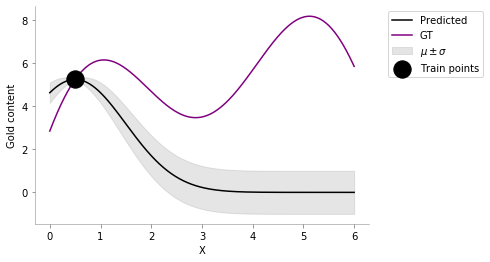

In [6]:
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
gp.fit(train_X, train_y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted')
plt.plot(x, f(x), 'purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='black', s=300, zorder=10, label='Train points')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())

Nice, we can see now that the posterior has changed. We are very certain about the points in the vicinity of x = 0.5, but, very uncertain far away from it. So, we now come to the key idea.

#### Active learning procedure

1. Choose the point having highest uncertainty
2. Add the point to train set
3. Train on the new train set
4. Go to 1 till convergence or budget elapsed

In [7]:
# Stopping criteria is 10 iterations
for i in range(10):
    # Fit on current train set
    gp.fit(train_X, train_y.flatten())
    # predict on current pool set
    y_pred, sigma = gp.predict(x, return_std=True)
    plt.plot(x, y_pred, 'k', label='Predicted')
    plt.plot(x, f(x), 'purple', label='GT')
    plt.xlabel("X")
    plt.ylabel("Gold content")
    plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
    plt.scatter(train_X, train_y, color='black', s=300, zorder=10, label='Train points')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(f"Iteration: {i}")
    format_axes(plt.gca())
    plt.ylim((1, 9))
    plt.xlim((-1, 7))
    dirName = 'active-gp-img'
    os.makedirs(dirName, exist_ok=True)
    plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight")
    plt.close()
    
    # Choose the next point with highest sigma
    next_ix = np.argmax(sigma)
    next_x = x[next_ix]
    # Add new point with highest uncertainty to the pool set
    train_X = np.vstack([train_X, [x[next_ix]]])
    train_y = f(train_X)

Let us now write a simple function to create the animation shown at the top of the post!

In [8]:
!convert -delay 40 -loop 0 active-gp-img/*.png active-gp.gif

----

### Multi-Armed Bandit with Gaussian Processes

Now let us explore a problem with similar problem setting. Earlier in the active learning problem, our motivation for placing the sensors was to predict the values at sensor locations where we did not have sensors. We had chosen the reduction of maximum entropy (variance) as the guide (objective) to select the next sensor location. In other words, we wanted to best predict the underlying gold distribution over the locations.

In the problem of Multi-Armed Bandit, instead, we are try to find the location where we have the maximum gold content is. We are not actually interested in knowning the distribution but just the location of our global optima. In other words, we just want the location where we can drill to get the most gold.

#### Plotting our prior model

Our prior model doesn't know much and assumes a smooth relationship between points via an RBF kernel. This is exactly the same as before.

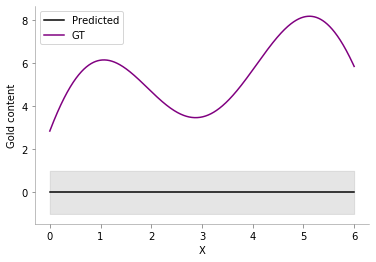

In [9]:
gp = GaussianProcessRegressor()
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted', lw=1.5)
plt.plot(x, f(x), 'purple', label='GT', lw=1.5)
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2)
plt.legend()
format_axes(plt.gca())

In [10]:
def rargmax(b):
    """Randomly tie breaking argmax"""
    return np.random.choice(np.flatnonzero(b == b.max()))

In [11]:
class ACQ:
    def acq_fn(self, *args, **kwargs):
        raise NotImplemented
    
    def __str__(self):
        return self.__class__.__name__
    
    def __call__(self, *args, **kwargs):
        return self.acq_fn(*args, **kwargs)

In [12]:
class ACQ1(ACQ):
    def acq_fn(self, gp_reg, x, lam = 0.4, **kwrags):
        """
        gp_reg: sklearn.GPRegresssor
        lam: float, where the objective is: \mu(x) + \lambda \sigma(x)
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)

        return y_pred + lam*sigma

### Adding a point to the train set

Let us now add a point to the train set and see how our posterior changes after we fit the model to the new data. I am going to add `(x = 0.5, y = f(0.5))` into the train set now. Here, in addition to the uncertainity returned by the `sklearn`s `GuassianProcessRegressor` is a green colored acqusition function. We have defined this acqusition function to be a linear combination of the mean and the standard deviation we recieved from the `sklearn`s `GuassianProcessRegressor`.

The intuition of using this acquisition function is that we are interested in finding the global mean so taking into account the mean returned by the `GuassianProcessRegressor` would be a good idea. Additionally we would like explore too, else we might be stuck in a local minima if the value of `lam` is low (see below).

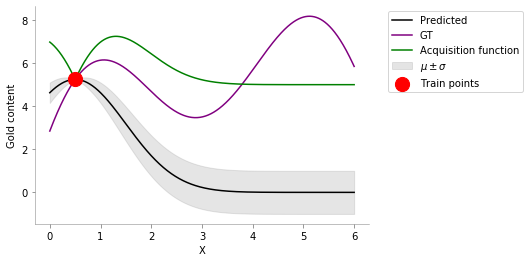

In [13]:
acq_obj = ACQ1()

train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
gp.fit(train_X, train_y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted')
plt.plot(x, f(x), 'purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=200, zorder=10, label='Train points')
plt.plot(x, acq_obj(gp, x, 5), label='Acquisition function', color='green')
format_axes(plt.gca())
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

We define a big plotting function below for saving us the trouble down the road.

In [14]:
def plot_acquisition(
        train_X, train_y,
        acq_class, acq_params={},
        ylim0=None, xlim0=None,
        ylim1=None, xlim1=None,
        y1scale='linear', it = 10,
        seed = 2
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[1].set_yscale(y1scale)
        
        # limits
        ax[0].set_ylim(ylim0) if ylim0 is not None else ax[0].set_ylim(min(f(x)-.5), max(f(x))+.5)
        ax[0].set_xlim(xlim0) if xlim0 is not None else ax[0].set_xlim(min(x)-.5, max(x)+.5)
        ax[1].set_ylim(ylim1) if ylim1 is not None else None
        ax[1].set_xlim(xlim1) if xlim1 is not None else ax[1].set_xlim(min(x)-.5, max(x)+.5)
        
        
        # fitting
        gp.fit(train_X, train_y.flatten())
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, x, t=i+1, **acq_params, train_y=train_y)
        ax[1].plot(x, acquisition, 
                   label='Acquisition function', color='green')
        
        # predict on current pool set
        y_pred, sigma = gp.predict(x, return_std=True)
        ax[0].plot(x, y_pred, 'k', label='Predicted')
        ax[0].plot(x, f(x), 'purple', label='GT')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Gold content")
        ax[0].fill_between(x.flatten(), y_pred+sigma,
                           y_pred-sigma, color='gray',
                           alpha=0.2, label=r'$\mu \pm \sigma$')
        ax[0].scatter(train_X, train_y, color='black', s=100, zorder=10, label='Train points')
        ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax[1].set_ylabel(str(acq_obj))
        hyperparams = ' | '.join([str(k)+': '+str(v) for k, v in acq_params.items()])
        ax[0].set_title(f"Iteration: {i} & HParam(s) → " + hyperparams)
        
        # Choose the next point with highest sigma
        max_mu = np.max(train_y).flatten()[0]
        next_ix = rargmax(acquisition)
        next_x = x[next_ix]

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(x[next_ix], acquisition[next_ix], marker='X',s=50,
                      c='orange', zorder=10, label='maxima (tie randomly broken)')
        ax[0].scatter(x[next_ix], f(x[next_ix]), color='red',
                      s=200, zorder=-10, label='New Added points')
        ax[0].legend(bbox_to_anchor=(1.1,1), loc="upper left")
        ax[1].legend(bbox_to_anchor=(1.1,0.5), loc="upper left")
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)
        max_till_now.append(np.argmax(train_y))
        format_axes(ax[0])
        format_axes(ax[1])

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './MAB_pngs/'+str(acq_obj)+'/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight")
        plt.close()
    return dirName, max_till_now

In [15]:
gifDir = 'MAB_gifs'
os.makedirs(gifDir, exist_ok=True)
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()

In [16]:
acq_params = {'lam': 1}

dirName, _ = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 10)
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-1.gif

Let us now try different hyper parameters for `ACQ1`. We can see that on increasing `lam` we "explore" more! In the below case we can easily see since we didn't give too much importance to the standard deviation (low `lam`) returned from `GuassianProcessRegressor` we got stuck in local minima.

![](MAB_gifs/mab-gp-1.gif)

In [17]:
acq_params = {'lam': 5}

dirName, _ = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 10)
)

In [18]:
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-5.gif

Below we can see that this choice of `lam` is still a little smaller than we like (we would like to see that we get to exploit the location where the gold is the most.).

![](MAB_gifs/mab-gp-5.gif)

In [19]:
acq_params = {'lam': 10}

dirName, mtn_acq = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 14)
)

In [20]:
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-10.gif

Perfect!

![](MAB_gifs/mab-gp-10.gif)

### Random
Let us also look at how the random performs.

In [21]:
# Code is heavily borrowed from: https://modal-python.readthedocs.io/en/latest/_modules/modAL/acquisition.html#max_PI
class Rand(ACQ):
    def acq_fn(
        self, gp_reg, x, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        return np.random.uniform(size=x.shape[0])

In [22]:
dirName, mtn_rand = plot_acquisition(
    train_X, train_y,
    Rand, ylim1=(0, 1.2)
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/rand.gif

We have here implemented a random method as a baseline. Notice, random method can find a location near the global maximum but is not able to "exploit" it as it randomly chooses to "explore" here and there.

![](MAB_gifs/rand.gif)

### Probability of improvement (PI)

Let us look into our next method for the MAB maximisation problem. As before, we want to balance or trade-off between exploration and exploitation. The idea behind the algorithm is fairly simple - choose the next point as the one which has the highest probability of improvement over the current max ($\mu^+$).


Let's understand this concept via two cases:

1. We have two points of similar means (of function values (gold in our case)). We now want to choose one of these to obtain the labels or values. We will choose the one with higher variance. This basically says that given same exploitability, we choose the one with higher exploration value.
2. We have two points having same variance. We would now choose the point with the higher mean. This basically says that given same explorability, we will choose the one with higher exploitation value.


1. Let $\mu^+$ be the current highest value of the function
2. Let $\epsilon$ be close to zero
3. Choose $x^* = arg\,max(P(f(x)) > (\mu^+ +\epsilon))$

This can be given as: $x^* = _{arg\,max_{x}} \Phi(\frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)})$ where
$\Phi(.)$ indicates the CDF.

In [23]:
# Code is heavily borrowed from: https://modal-python.readthedocs.io/en/latest/_modules/modAL/acquisition.html#max_PI
class PI(ACQ):
    def acq_fn(
        self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        cdf = ndtr((y_pred - mu - eps)/sigma)
        return cdf

Text(0.5, 0, 'X')

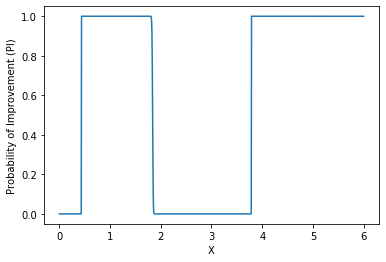

In [24]:
p = PI()
plt.plot(x, p(gp, x))
plt.ylabel("Probability of Improvement (PI)")
plt.xlabel("X")

Here if we look at `eps`, we see that setting the value of `eps` to be higher, results in more exploration.

In [25]:
eps = 1
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-1e10, 10**10)),
    y1scale='log', acq_params = acq_params
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

![](MAB_gifs/mab-gp-pi-eps1.gif)

In [26]:
eps = 3
acq_params = {
    'eps': eps
}

dirName, mtn_pi = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-1e10, 10**10)),
    y1scale='log', acq_params = acq_params
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

![](MAB_gifs/mab-gp-pi-eps3.gif)

In [27]:
eps = 5
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-10**10, 10**10)),
    y1scale='log', acq_params = acq_params
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

![](MAB_gifs/mab-gp-pi-eps5.gif)

### Expected Improvement

Probability of improvement only looked at `how likely` is an improvement, but, shouldn't we be looking into `how much` we can improve. The next criterion called Expected Improvement (EI) looks into both :)

\begin{equation}
    EI(x)=
    \begin{cases}
      (\mu(x) - \mu^+ - \epsilon)\Phi(Z) + \sigma(x)\phi(Z), & \text{if}\ \sigma(x) > 0 \\
      0 & \text{if}\ \sigma(x) = 0 
    \end{cases}
  \end{equation}
 $$Z= \frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)}$$
 where $\Phi(.)$ indicates CDF and $\phi(.)$ indicates pdf

In [28]:
class EI(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        #ei = np.zeros_like(x)
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        #ei[sigma<1e-10] = 0
        z = (y_pred - mu - eps)/sigma
        return (y_pred - mu - eps)*ndtr(z) + sigma*norm.pdf(z)

In [29]:
eps = 0.01
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((0, 2)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps0.01.gif)

In [30]:
eps = 3
acq_params = {
    'eps': eps
}

dirName, mtn_ei = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((0, 2)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps3.gif)

In [31]:
eps = 5
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((0, 2)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps5.gif)

We see that using the value of `eps = 3` was most beneficial as we were able to find a value near the global optimum and after finding we exploited the location too!

Using `esp = 5` and `eps = 0.01` results in too much and too low exploration respectively!

We have seen two closely related methods, The probability of improvement and the Expected improvement. We can think of these two to be related to the ideas that we commonly are familiar with `risk` and `gain` respectively.

It seems natural to see how these metrics change for each of the points. Below we select increment sensor locations using the policy `acq_class` and see the `PI` and `EI` for each of the points for each of the iterations.

In [32]:
def ei_pi_plot(
        train_X, train_y, i,
        ylim=None, xlim=None,
        yscale='log', xscale='log',
        seed = 2,
        pi_params={}, ei_params={},
    ):
    np.random.seed(seed)
    
    fig, ax = plt.subplots()
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)

    # fitting
    gp.fit(train_X, train_y.flatten())

    # for plotting scatter plot
    pi_obj = PI()
    ei_obj = EI()
    pi_acq = pi_obj(gp, x, **pi_params, train_y=train_y)
    ei_acq = ei_obj(gp, x, **ei_params, train_y=train_y)
    
    # predict on current pool set
    y_pred, sigma = gp.predict(x, return_std=True)
    ax.scatter(pi_acq, ei_acq, color='black', alpha=0.4, label='Location')
    ax.set_ylabel('EI_acq value')
    ax.set_xlabel('PI_acq value')
    pi_hyperparams = ': HParam(s) → '+' | '.join([str(k)+': '+str(v) for k, v in pi_params.items()])
    ei_hyperparams = ': HParam(s) → '+' | '.join([str(k)+': '+str(v) for k, v in ei_params.items()])
    
    # limits
    ax.set_ylim(ylim) if ylim is not None else None # ax.set_ylim(min(ei_acq), max(ei_acq)
    ax.set_xlim(xlim) if xlim is not None else None # ax.set_xlim(min(pi_acq), max(pi_acq))
    
    strr = str(pi_obj) + pi_hyperparams + '\n' + str(ei_obj) + ei_hyperparams
    ax.set_title(strr)

    ax.legend(bbox_to_anchor=(1.1,1), loc="upper left")
    format_axes(ax)
    
    pii = list(map(str, pi_params.values()))
    eii = list(map(str, ei_params.values()))
    params_str = '-'.join(pii + eii)
    dirName = './MAB_pngs/Ei_Pi_graph/'
    os.makedirs(dirName, exist_ok=True)
    plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight")
    plt.close()
    return (dirName)

In [33]:
pi_eps = [0.01, 0.03, 0.06, 0.12, 0.3, 0.6, 0.9, 1.2]
ei_eps = [0.01, 0.03, 0.06, 0.12, 0.3, 0.6, 0.9, 1.2]

for i, (pi_ep, ei_ep) in enumerate(zip(pi_eps, ei_eps)):
    pi_params = {'eps': pi_ep}
    ei_params = {'eps': ei_ep}

    dirName = ei_pi_plot(
        train_X, train_y, i,
        pi_params = pi_params,
        ei_params = ei_params,
        yscale='linear', xscale='linear',
        ylim=(0, 0.28), xlim=(0, 1.05),
    )

# gify!
!convert -delay 50 -loop 0 {dirName}/*.png {gifDir}/ei_pi_graph.gif

![](MAB_gifs/ei_pi_graph.gif)

### Probability of Improvement + $\lambda \  \times$ Expected Improvement

In [34]:
class EI_PI(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps_pi=0.01, eps_ei=0.01, lam=.3, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        
        # ei
        z = (y_pred - mu - eps_ei)/sigma
        ei_acq = (y_pred - mu - eps_ei)*ndtr(z) + sigma*norm.pdf(z)
        
        # pi
        pi_acq = ndtr((y_pred - mu - eps_pi)/sigma)
        return pi_acq + lam * ei_acq

In [35]:
acq_params = {
    'eps_pi': 2,
    'eps_ei': 4,
    'lam': 1,
}

dirName, mtn_ei_pi = plot_acquisition(
    train_X, train_y,
    EI_PI, ylim1=((0, 10)),
    acq_params=acq_params,
    y1scale='log',
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei_pi.gif

![](MAB_gifs/mab-gp-ei_pi.gif)

### GP-UCB



In [36]:
class GP_UCB(ACQ):
    def acq_fn(self, gp_reg, x, t, mu=5.,
               v = 1., delta=1., **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        t: Iteration number (1, ..)
        """
        d = x.shape[1]
        y_pred, sigma = gp_reg.predict(x, return_std=True)    
        k = np.sqrt( v* (2*  np.log( (t**(d/2. + 2))*(np.pi**2)/(3. * delta)  )))
        return y_pred + k*sigma

In [37]:
acq_params = {
    'v': 1,
    'delta': 1
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb1-1.gif

![](MAB_gifs/mab-gp-gp_ucb1-1.gif)

In [38]:
acq_params = {
    'v': 3,
    'delta': 1
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb3-1.gif

![](MAB_gifs/mab-gp-gp_ucb3-1.gif)

In [39]:
acq_params = {
    'v': 1,
    'delta': 3
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb1-3.gif

![](MAB_gifs/mab-gp-gp_ucb1-3.gif)

In [40]:
acq_params = {
    'v': 3,
    'delta': 3
}

dirName, mtn_gp_ucb = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb3-3.gif

![](MAB_gifs/mab-gp-gp_ucb3-3.gif)

### Comparison between all the methods

Below we have a graph showing a comparison between the methods discussed above. We have chosen the hyper-parameters that gave us the best performance during our basic hyper-parameter search.

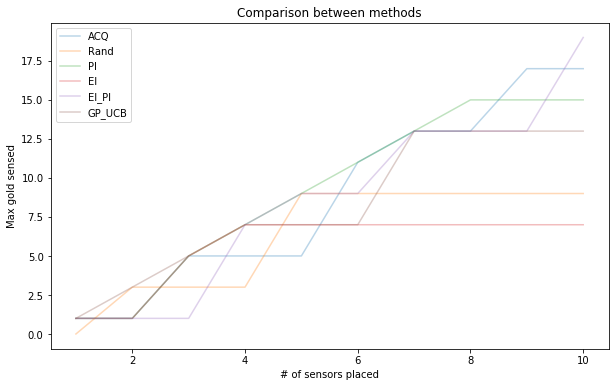

In [41]:
mtns = [mtn_acq, mtn_rand, mtn_pi, mtn_ei, mtn_ei_pi, mtn_gp_ucb]
names = ['ACQ', 'Rand', 'PI', 'EI', 'EI_PI', 'GP_UCB']
xx = range(1, 11)
plt.figure(figsize=(10, 6))
for n, m in zip(names, mtns):
    plt.plot(xx, m, label=n, alpha=0.3)
plt.legend()
plt.xlabel('# of sensors placed')
plt.ylabel('Max gold sensed')
plt.title('Comparison between methods')
plt.show()